# Paytm

In [1]:
import glob
import pandas as pd
import gensim
import spacy
import numpy as np
import tqdm.notebook as tqdm
from pprint import pprint

import sys
sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')
from utils.helper import preprocess_tweet, sentence_to_words, lemmatization

In [2]:
df = pd.read_csv('./../../data/fintech/paytm/paytm.csv', engine='python')

In [3]:
df.shape

(1006178, 27)

In [16]:
pre_df = df[df['date'] < '2020-02-01']
post_df = df[df['date'] >= '2020-02-01']

In [17]:
pre_df = pre_df.sample(frac=0.1, random_state=42)
post_df = post_df.sample(frac=0.1, random_state=42)

In [18]:
pre_df.shape

(50256, 27)

In [19]:
post_df.shape

(50354, 27)

## Preprocessing

In [20]:
# Preprocess tweets
pre_df['preprocessed'] = pre_df['tweet'].apply(preprocess_tweet)
post_df['preprocessed'] = post_df['tweet'].apply(preprocess_tweet)

In [21]:
# Create words data
pre_data = pre_df['preprocessed'].values.tolist()
# fintech_data_words = list(sentence_to_words(fintech_data))
pre_data_words = list(sentence_to_words(pre_data))

# Create words data
post_data = post_df['preprocessed'].values.tolist()
# fintech_data_words = list(sentence_to_words(fintech_data))
post_data_words = list(sentence_to_words(post_data))

In [22]:
# For pre-covid period
# Build bigram and trigram models
pre_bigram = gensim.models.phrases.Phrases(pre_data_words, min_count=5, threshold=10, connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)
pre_trigram = gensim.models.phrases.Phrases(pre_bigram[pre_data_words], threshold=100)

pre_bigram_model = gensim.models.phrases.Phraser(pre_bigram)
pre_trigram_model = gensim.models.phrases.Phraser(pre_trigram)

# For post-covid period
# Build bigram and trigram models
post_bigram = gensim.models.phrases.Phrases(post_data_words, min_count=5, threshold=10, connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)
post_trigram = gensim.models.phrases.Phrases(post_bigram[post_data_words], threshold=100)

post_bigram_model = gensim.models.phrases.Phraser(post_bigram)
post_trigram_model = gensim.models.phrases.Phraser(post_trigram)

In [23]:
# Remove stopwords
pre_df['preprocessed'] = pre_df['preprocessed'].apply(gensim.parsing.preprocessing.remove_stopwords)
post_df['preprocessed'] = post_df['preprocessed'].apply(gensim.parsing.preprocessing.remove_stopwords)

In [24]:
pre_df['sep_words'] = pre_df['preprocessed'].apply(lambda x: list(sentence_to_words([x]))[0])
post_df['sep_words'] = post_df['preprocessed'].apply(lambda x: list(sentence_to_words([x]))[0])

In [25]:
pre_df['bigram'] = pre_df['sep_words'].apply(lambda x: pre_bigram_model[x])
post_df['bigram'] = post_df['sep_words'].apply(lambda x: post_bigram_model[x])

In [26]:
pre_df['trigram'] = pre_df['bigram'].apply(lambda x: [pre_trigram_model[x]])
post_df['trigram'] = post_df['bigram'].apply(lambda x: [post_trigram_model[x]])

In [27]:
pre_id2word = gensim.corpora.Dictionary(pre_df['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_df['bigram'].values.tolist())

In [28]:
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_df['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_df['bigram'].values.tolist()]

## Base Model

### Training

In [29]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=10,
                                        random_state=42,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True)

In [30]:
pprint(pre_lda_model.print_topics())
pre_doc_lda = pre_lda_model[pre_corpus]

[(0,
  '0.086*"paytm" + 0.015*"product" + 0.013*"batch" + 0.012*"buy" + '
  '0.011*"mall" + 0.010*"lo" + 0.009*"ki" + 0.006*"rs" + 0.006*"ani" + '
  '0.006*"bhai"'),
 (1,
  '0.025*"paytm" + 0.021*"hai" + 0.016*"se" + 0.013*"ka" + 0.011*"ko" + '
  '0.009*"bhi" + 0.009*"ke" + 0.009*"ki" + 0.008*"overs" + 0.008*"sir"'),
 (2,
  '0.039*"paytm" + 0.018*"days" + 0.018*"money" + 0.015*"fastag" + '
  '0.015*"refund" + 0.015*"issue" + 0.012*"time" + 0.012*"help" + '
  '0.011*"response" + 0.011*"order"'),
 (3,
  '0.068*"paytm" + 0.023*"app" + 0.020*"number" + 0.017*"use" + '
  '0.016*"customer_care" + 0.014*"postpaid" + 0.013*"hi" + 0.012*"able" + '
  '0.011*"update" + 0.010*"help"'),
 (4,
  '0.081*"paytm" + 0.047*"account" + 0.034*"thanks" + 0.033*"hi" + '
  '0.023*"available" + 0.019*"know" + 0.016*"numbers" + 0.014*"way" + '
  '0.013*"aware" + 0.011*"appropriate_action"'),
 (5,
  '0.073*"paytm" + 0.052*"number" + 0.047*"hi" + 0.043*"dm" + 0.033*"share" + '
  '0.027*"assist" + 0.027*"registered

In [31]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=10,
                                        random_state=42,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True)

In [32]:
pprint(post_lda_model.print_topics())
post_doc_lda = post_lda_model[post_corpus]

[(0,
  '0.091*"paytm" + 0.032*"account" + 0.021*"money" + 0.020*"hi" + '
  '0.019*"number" + 0.018*"rs" + 0.017*"help" + 0.017*"payment" + '
  '0.017*"wallet" + 0.014*"upi"'),
 (1,
  '0.079*"paytm" + 0.018*"chinese" + 0.016*"india" + 0.015*"ban" + '
  '0.015*"china" + 0.014*"indian" + 0.013*"app" + 0.012*"apps" + 0.011*"like" '
  '+ 0.008*"use"'),
 (2,
  '0.034*"recharge" + 0.019*"rewards" + 0.018*"entered" + 0.017*"weeks_sunday" '
  '+ 0.012*"complaint" + 0.011*"jio" + 0.009*"closed" + 0.009*"shows" + '
  '0.009*"exchange" + 0.009*"true"'),
 (3,
  '0.075*"paytm" + 0.025*"app" + 0.016*"cash" + 0.015*"google" + 0.013*"store" '
  '+ 0.010*"removed" + 0.010*"free" + 0.010*"google_play" + 0.009*"play_store" '
  '+ 0.008*"games"'),
 (4,
  '0.068*"paytm" + 0.025*"thanks" + 0.023*"app" + 0.022*"hi" + 0.013*"aware" + '
  '0.013*"issue" + 0.012*"appropriate_action" + 0.012*"official_communication" '
  '+ 0.012*"highlighting" + 0.011*"fake_callersmessages"'),
 (5,
  '0.069*"paytm" + 0.038*"refun

### Evaluation

In [33]:
pre_coherence_model_lda = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_df['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_lda = pre_coherence_model_lda.get_coherence()
print('Pre-COVID Coherence Score: ', pre_coherence_lda)

Pre-COVID Coherence Score:  -6.567719652197832


In [34]:
post_coherence_model_lda = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_df['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_lda = post_coherence_model_lda.get_coherence()
print('Post-COVID Coherence Score: ', post_coherence_lda)

Post-COVID Coherence Score:  -6.80113400979737


## Hyper-parameter tuning

In [35]:
def compute_coherence_values(corpus, dictionary, k, alpha, beta, texts, coherence='u_mass'):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           eta=beta)
    
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, 
                                                        texts=texts, 
                                                        dictionary=dictionary, 
                                                        coherence=coherence)
    
    return coherence_model_lda.get_coherence()

### Pre-COVID

In [36]:
grid = {}
grid['Validation_Set'] = {}

In [37]:
corpus = pre_corpus

In [38]:
# Topics range
min_topics = 2
max_topics = 31
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

In [39]:
iterations = len(topics_range) * len(alpha) * len(beta) * len(corpus_sets)

In [40]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=iterations)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=pre_id2word, 
                                                  k=k, alpha=a, beta=b,
                                                  texts=pre_df['bigram'].values.tolist(),
                                                  coherence='u_mass')
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pre_df_result = pd.DataFrame(model_results)
    pbar.close()

  0%|          | 0/1740 [00:00<?, ?it/s]

In [ ]:
pre_df_result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,-10.280174
1,75% Corpus,2,0.01,0.31,-10.335512
2,75% Corpus,2,0.01,0.61,-10.445016
3,75% Corpus,2,0.01,0.91,-10.100003
4,75% Corpus,2,0.01,symmetric,-10.294562
...,...,...,...,...,...
1735,100% Corpus,30,asymmetric,0.01,-12.499946
1736,100% Corpus,30,asymmetric,0.31,-12.093027
1737,100% Corpus,30,asymmetric,0.61,-12.291410
1738,100% Corpus,30,asymmetric,0.91,-12.619307


In [ ]:
pre_topics_score = []
for i in pre_df_result['Topics'].value_counts().index:
    data = []
    data.append(i)
    temp = pre_df_result[(pre_df_result['Topics'] == i) & (pre_df_result['Alpha'] == 'symmetric') & (pre_df_result['Beta'] == 'symmetric')]
    max_value = temp['Coherence'].max()
    data.append(max_value)
    pre_topics_score.append(data)

In [ ]:
pre_ts_df = pd.DataFrame(pre_topics_score)
pre_ts_df.columns = ['topics', 'coherence']

In [ ]:
pre_ts_df.sort_values('topics', inplace=True)
pre_ts_df.head()

,topics,coherence
0,2,-8.734477
15,3,-9.658440
27,4,-8.821794
26,5,-9.362972
25,6,-8.475583


<AxesSubplot: xlabel='topics'>

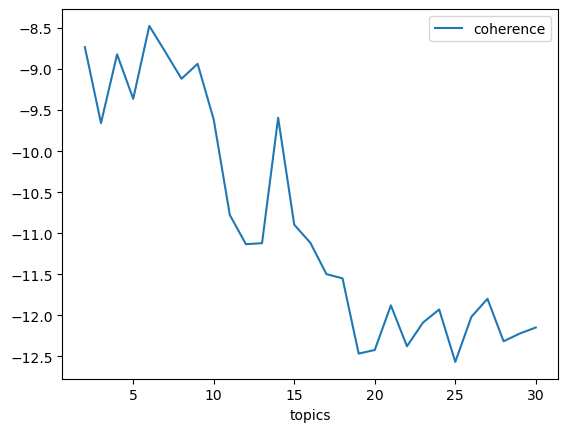

In [ ]:
pre_ts_df.plot.line(x='topics', y='coherence')

In [ ]:
pre_df_result[pre_df_result['Topics'] == 2]

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,-10.280174
1,75% Corpus,2,0.01,0.31,-10.335512
2,75% Corpus,2,0.01,0.61,-10.445016
3,75% Corpus,2,0.01,0.91,-10.100003
4,75% Corpus,2,0.01,symmetric,-10.294562
5,75% Corpus,2,0.31,0.01,-10.532594
6,75% Corpus,2,0.31,0.31,-10.070990
7,75% Corpus,2,0.31,0.61,-9.732020
8,75% Corpus,2,0.31,0.91,-10.114306
9,75% Corpus,2,0.31,symmetric,-9.727599


### Post-COVID

In [ ]:
grid = {}
grid['Validation_Set'] = {}

In [ ]:
corpus = post_corpus

In [ ]:
# Topics range
min_topics = 2
max_topics = 31
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

In [ ]:
iterations = len(topics_range) * len(alpha) * len(beta) * len(corpus_sets)

In [ ]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=iterations)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=post_id2word, 
                                                  k=k, alpha=a, beta=b,
                                                  texts=post_df['bigram'].values.tolist(),
                                                  coherence='u_mass')
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    post_df_result = pd.DataFrame(model_results)
    pbar.close()

  0%|          | 0/870 [00:00<?, ?it/s]

In [ ]:
post_df_result.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,-4.837035
1,75% Corpus,2,0.01,0.31,-5.057095
2,75% Corpus,2,0.01,0.61,-5.079629
3,75% Corpus,2,0.01,0.91,-5.075933
4,75% Corpus,2,0.01,symmetric,-4.716801


In [ ]:
post_topics_score = []
for i in post_df_result['Topics'].value_counts().index:
    data = []
    data.append(i)
    temp = post_df_result[(post_df_result['Topics'] == i) & (post_df_result['Alpha'] == 'asymmetric') & (post_df_result['Beta'] == 'symmetric')]
    max_value = temp['Coherence'].max()
    data.append(max_value)
    post_topics_score.append(data)

In [ ]:
post_ts_df = pd.DataFrame(post_topics_score)
post_ts_df.columns = ['topics', 'coherence']

In [ ]:
post_ts_df.sort_values('topics', inplace=True)
post_ts_df.head()

,topics,coherence
0,2,-5.362069
15,3,-4.722504
27,4,-3.505113
26,5,-4.111553
25,6,-5.929709


<AxesSubplot: xlabel='topics'>

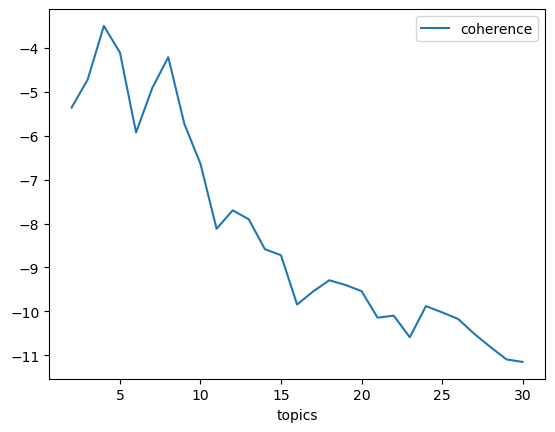

In [ ]:
post_ts_df.plot.line(x='topics', y='coherence')

In [ ]:
post_df_result[(post_df_result['Topics'] == 2)]

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,-4.837035
1,75% Corpus,2,0.01,0.31,-5.057095
2,75% Corpus,2,0.01,0.61,-5.079629
3,75% Corpus,2,0.01,0.91,-5.075933
4,75% Corpus,2,0.01,symmetric,-4.716801
5,75% Corpus,2,0.31,0.01,-4.865281
6,75% Corpus,2,0.31,0.31,-5.155205
7,75% Corpus,2,0.31,0.61,-4.750556
8,75% Corpus,2,0.31,0.91,-4.684258
9,75% Corpus,2,0.31,symmetric,-4.255566


## Final Models

In [ ]:
pre_final_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=2,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='asymmetric',
                                        eta=0.01)

In [ ]:
pre_final_coherence_model_lda = gensim.models.CoherenceModel(model=pre_final_lda_model, 
                                                    texts=pre_df['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_final_coherence_lda = pre_final_coherence_model_lda.get_coherence()
print('Pre-COVID Coherence Score: ', pre_final_coherence_lda)

Process AccumulatingWorker-18298:
Process AccumulatingWorker-18294:
Process AccumulatingWorker-18292:
Process AccumulatingWorker-18293:
Process AccumulatingWorker-18295:
Process AccumulatingWorker-18296:
Process AccumulatingWorker-18297:
Traceback (most recent call last):
  File "/Users/pushkar/miniforge3/envs/project/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/Users/pushkar/miniforge3/envs/project/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/Users/pushkar/miniforge3/envs/project/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/Users/pushkar/miniforge3/envs/project/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/Users/pushkar/miniforge3/envs/project/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
Traceback (most rece

In [ ]:
post_final_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=2,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='asymmetric',
                                        eta='symmetric')

In [ ]:
post_final_coherence_model_lda = gensim.models.CoherenceModel(model=post_final_lda_model, 
                                                    texts=post_df['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_final_coherence_lda = post_final_coherence_model_lda.get_coherence()
print('Pre-COVID Coherence Score: ', post_final_coherence_lda)

Pre-COVID Coherence Score:  0.6471847782036786
